# Gaussian Process likelihood

In this notebook we demonstrate how to train a Gaussian Process (GP) to act as a synthetic likelihood to accelerate inference. 

In this example we will:
1. Generate some simulated data.
2. Train a Gaussian Process (GP) to act as a synthetic likelihood.
3. Run an MCMC with our synthetic likelihood.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zeus
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## 1. Generating some data

Like many all of the other notebooks in this repo we start by simulating our data. For the full version of this see `MCMC_zeus.ipynb`.

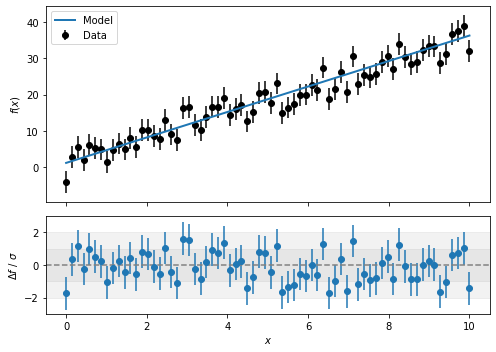

In [2]:
np.random.seed(100) # We set the random seed for numpy so we get the
                    # same synthetic data each time the notebook is run.

def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

m_true = 3.5 
c_true = 1.2 

num_points = 70
x = np.linspace(0, 10, num_points)

sigma = 3.0

data = np.random.normal(loc=straight_line(x, m_true, c_true), scale=sigma)

fig, ax = plt.subplots(2,1,sharex=True, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

ax[0].errorbar(x, data, yerr=sigma, fmt="o", color='k', zorder=1, label='Data')
ax[0].plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='Model')
ax[0].legend()
ax[0].set_ylabel(r'$f(x)$')

ax[1].errorbar(x, (data-straight_line(x, m_true, c_true))/sigma, yerr=1., fmt="o")
ax[1].axhline(0., linestyle='--', color='grey')
ax[1].axhspan(-1,1, alpha=0.1, color='grey')
ax[1].axhspan(-2,2, alpha=0.1, color='grey')
ax[1].set_ylim(-3,3)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\Delta f \ / \ \sigma$')

plt.tight_layout()
plt.show()

## 2. Synthetic likelihood

We will now move onto developing our GP likelihood.

A GP is a nonparametric probabilistic machine learning algorithm that can be used for regression or classification tasks. For details see [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/chapters/RW.pdf). A key part of a GP is the covariance function or *kernel*, this kernel will determine the kind if functions that the GP can approximate. For this is example we use the Radial-Basis Function (RBF) kernel, this has the form 

$$k(x, x') = \exp{\left[-\frac{(x - x')^2}{2l^2}\right]}.$$

We will be using the scikit-learn implementation of the GP. In the cell below we define our kernel and initalise the GP.

In [3]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

To generate for our GP we will run a short MCMC, this MCMC will not converge but will provide samples in the right region of the parameter space. To run this short chain we will be using the same log-prior, log-likelihood, and log-probability defenitions from `MCMC_zeus.ipynb`.

In [4]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, data, sigma, x), loglike(theta, data, sigma, x)

We should note that we have made a small modification to `logpost`. This function now returns a `tuple` containing the sum of the likelihood and the prior, and the likelihood evaluation. This means we can log the likelihood evaluations as the MCMC runs such that we don't have to recompute them. This is something that would be essential if our model was more expensive to evaluate.

In [5]:
num_dim=2
num_walkers=4

random_m = np.random.normal(loc=3, scale=10, size=(num_walkers, ))
random_c = np.random.uniform(-10,10, size=(num_walkers, ))
init_pos = np.vstack([random_m, random_c]).T

sampler = zeus.EnsembleSampler(num_walkers, num_dim, logpost, args=[data, sigma, x])
sampler.run_mcmc(init_pos, 500)

Initialising ensemble of 4 walkers...
Sampling progress : 100%|██████████| 500/500 [00:00<00:00, 552.86it/s]


We concatenate all the samples and the likelihood evaluations from the walkers.

In [6]:
chain_likes = sampler.get_blobs(flat=True).reshape(-1,1) # reshape is required to keep sklearn happy.
flat_chain = sampler.get_chain(flat=True)

Before we train our GP we standardize our samples and likelihoods, this helps with training.

In [7]:
yscaler = StandardScaler()
xscaler = StandardScaler()

trainy = yscaler.fit_transform(chain_likes)
trainx = xscaler.fit_transform(flat_chain)

Now we train our GP!

In [8]:
gaussian_process.fit(trainx, trainy)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

## MCMC with synthetic likelihood

To run an MCMC using our GP to replace the likelihood evaluation we need to define some new functions for the log-likelihood and the log-probability.

In [9]:
def GPlike(theta):

    return yscaler.inverse_transform(gaussian_process.predict(xscaler.transform(theta.reshape(1,-1))))[0]

def GPpost(theta):
    
    return logprior(theta) + GPlike(theta)

It should be noted that these functions now only take the parameters $\theta$ as input. This highlights a downside to this method, that being that the GP has been trained to predict the likelihood evaulated for a given observation. This means we would have to retrain our GP if we wanted to analyse a different observation.

Now we run an MCMC with our GP likelihood. We monitor convergence in the same way as in `MCMC_zeus.ipynb`.

In [10]:
cb0 = zeus.callbacks.MinIterCallback(nmin=1000)
cb1 = zeus.callbacks.AutocorrelationCallback(ncheck=100, dact=0.01, nact=50, discard=0.5)

max_steps = 50000 # The maximum number of steps to run the MCMC.
num_dim = 2 # The number of dimensions of our problem.
num_walkers = 10

sampler = zeus.EnsembleSampler(num_walkers, num_dim, GPpost)
sampler.run_mcmc(flat_chain[-np.random.choice(100,10),:], max_steps, callbacks=[cb0, cb1])

Initialising ensemble of 10 walkers...
Sampling progress :   3%|▎         | 1400/50000 [00:16<09:35, 84.51it/s]


We discard the first $10\tau$ steps as we did in `MCMC_zeus.ipynb` and save the chain so it can be compared to the other methods.

In [11]:
discard = int(cb1.estimates[-1]*10)
np.save("GP_samples", sampler.get_chain(flat=True, discard=discard))